In [12]:
#files to be imported
import numpy as np
from matplotlib import pyplot as plt

import os ,sys, platform
import time
import cosmopower as cp

import mpi4py
import cobaya
from cobaya import run

#Planks Values
el = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)[31:]
el_te = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
Dl_TT = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)[31:]
Dl_TT_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)[31:]
Dl_TT_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)[31:]
Dl_EE = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_EE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_EE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_TE = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
#ells
dl_fac = el*(el+1)/(2*np.pi)
dl_fac_te = el_te*(el_te+1)/(2*np.pi)
#COSMOPOWER
tt_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_TT_NN')
ee_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_EE_NN')
te_emu = cp.cosmopower_PCAplusNN(restore=True,restore_filename='COSMO/cmb_TE_PCAplusNN')

def chi2(tre,teu,trb,pred): #chi^2 model
    #c = ((tre - pred)**2)/((pred)**2)
    c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
    chi = np.sum(c)
    return chi

#time ms to order of time
def time_hr(ms):
    ssm = ms*100
    seconds = int(ssm/100)
    minutes = int(seconds/60)
    hours = int(minutes/60)
    days = int(hours/24)
    sm = int(ssm - seconds*100)
    s = seconds - minutes*60 
    m = minutes - hours*60
    h = hours - days*24
    t = [sm,s,m,h,days]
    xi = ''
    if days == h == m == s == 0 :
        xi = str(sm) +'ms '
    elif days == h == m == 0:
        xi = str(s) +'s ' + str(sm) +' ms'
    elif days == h == 0:
        xi = str(m) + ' min ' + str(s) +'s ' + str(sm) +' ms'
    elif days == 0:
        xi = str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms'
    else :
        xi = str(days) +'days ' + str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms' 
    return xi #time 

def Find_val(inputrange,array):
    #finding the input value for the  minimum chi2 value
    min_chi2 = np.argmin(array) #position of minimum chi2
    vals = inputrange[min_chi2] #finding Input value of minimum chi2
    return vals

def Cosmo(xe,ze): # function for Cosmopower
    if xe == 'TT':
        tt_spectra = tt_emu.ten_to_predictions_np(ze)
        CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
    elif xe == 'EE':
        ee_spectra = ee_emu.ten_to_predictions_np(ze)
        CA = ee_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    elif xe == 'TE':
        te_spectra = te_emu.predictions_np(ze)
        CA = te_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    else:
        Print('Check Input Range or Data')
    return CO

def Cosmo_Power(omb,omc,h,tau,ns,As): #function for single value cosmopower
    DET = 'TT'
    params = {'omega_b': [omb],'omega_cdm': [omc],'h': [h/100],'tau_reio': [tau],'n_s': [ns],'ln10^{10}A_s': [np.log( 10**10 *(As*1e-9) )],}
    Para = [omb,omc,h,tau,ns,As]
    if DET=='TT':
        pred = Cosmo('TT',params)[31:]*dl_fac
        chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
    elif DET=='TE':
        pred = Cosmo('TE',params)*dl_fac_te
        chi = chi2(Dl_TE,Dl_TE_err_up,Dl_TE_err_bot,pred)
    elif DET=='EE':
        pred = Cosmo('EE',params)*dl_fac_te
        chi = chi2(Dl_EE,Dl_EE_err_up,Dl_EE_err_bot,pred)
    reference = [omb,omc,h,tau,ns,As,chi]
    return chi #parameter, prediction , chi value

def cobaya_com(Dpar):
    return (10 - np.log(Cosmo_Power(Dpar,0.12,68,0.0546,0.964,2.01)))

In [13]:
def cobaya_com1(omb,omc):
    return (10 - np.log(Cosmo_Power(omb,omc,68,0.0546,0.964,2.01)))

In [19]:
# below is parameters for 6 parameter cosmopower
info = {"likelihood": {"cosmo1": cobaya_com1}}
info["params"] = {
   "omb": {"prior": {"min": 0.001, "max": 0.1}, "ref": 0.022, "proposal": 0.0001},
    "omc": {"prior": {"min": 0.001, "max": 2}, "ref": 0.12, "proposal": 0.0001}
}
info["sampler"] = {"mcmc": {"Rminus1_stop": 0.001, "max_tries": 1000}}
updated_info, sampler = run(info)

[cosmo1] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: omb:0.022, omc:0.12
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {cosmo1: 150.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-06-11 20:05:33 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 12.620820 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


D:\Python\project_cosmology\cospo\lib\site-packages\cobaya\collection.py:651: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  self._data = pd.concat([


[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.977
[mcmc]  - Convergence of means: R-1 = 6.981053 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.965
[mcmc]  - Convergence of means: R-1 = 11.544898 after 192 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 320 samples accepted.
[mcmc]  - Acceptance rate: 0.898
[mcmc]  - Convergence of means: R-1 = 0.982521 after 256 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 400 samples accepted.
[mcmc]  - Acceptance rate: 0.829
[mcmc]  - Convergence of means: R-1 = 0.807685 after 320 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 480 samples accepted.
[mcmc]  - Acceptance rate: 0.763
[mcmc]  - Convergence of means: R-1 = 0.724186 after 3

C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 960 samples accepted.
[mcmc]  - Acceptance rate: 0.392
[mcmc]  - Convergence of means: R-1 = 0.600489 after 768 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1040 samples accepted.
[mcmc]  - Acceptance rate: 0.366
[mcmc]  - Convergence of means: R-1 = 0.249422 after 832 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1120 samples accepted.
[mcmc]  - Acceptance rate: 0.354
[mcmc]  - Convergence of means: R-1 = 0.253457 after 896 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1200 samples accepted.
[mcmc]  - Acceptance rate: 0.343
[mcmc]  - Convergence of means: R-1 = 0.233086 after 960 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 1280 samples accepted.
[mcmc]  - Acceptance rate: 0.327
[mcmc]  - Convergence of means: R-1 = 0.320860 after 1024 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1360 samples accepted.
[mcmc]  - Acceptance rate: 0.314
[mcmc]  - Convergence of means: R-1 = 0.327238 after 1088 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 1440 samples accepted.
[mcmc]  - Acceptance rate: 0.301
[mcmc]  - Convergence of means: R-1 = 0.172566 after 1152 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1520 samples accepted.
[mcmc]  - Acceptance rate: 0.296
[mcmc]  - Convergence of means: R-1 = 0.091396 after 1216 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1600 samples accepted.
[mcmc]  - Acceptance rate: 0.290
[mcmc]  - Convergence of means: R-1 = 0.056621 after 1280 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 1680 samples accepted.
[mcmc]  - Acceptance rate: 0.285
[mcmc]  - Convergence of means: R-1 = 0.045813 after 1344 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 1760 samples accepted.
[mcmc]  - Acceptance rate: 0.271
[mcmc]  - Convergence of means: R-1 = 0.023359 after 1408 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 1840 samples accepted.
[mcmc]  - Acceptance rate: 0.272
[mcmc]  - Convergence of means: R-1 = 0.020526 after 1472 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 1920 samples accepted.
[mcmc]  - Acceptance rate: 0.269
[mcmc]  - Convergence of means: R-1 = 0.014492 after 1536 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 2000 samples accepted.
[mcmc]  - Acceptance rate: 0.268
[mcmc]  - Convergence of means: R-1 = 0.012811 after 1600 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 2080 samples accepted.
[mcmc]  - Acceptance rate: 0.270
[mcmc]  - Convergence of means: R-1 = 0.013773 after 1664 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2160 samples accepted.
[mcmc]  - Acceptance rate: 0.264
[mcmc]  - Convergence of means: R-1 = 0.013600 after 1728 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2240 samples accepted.
[mcmc]  - Acceptance rate: 0.264
[mcmc]  - Convergence of means: R-1 = 0.017669 after 1792 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2320 samples accepted.
[mcmc]  - Acceptance rate: 0.262
[mcmc]  - Convergence of means: R-1 = 0.011696 after 1856 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 2400 samples accepted.
[mcmc]  - Acceptance rate: 0.258
[mcmc]  - Convergence of means: R-1 = 0.018721 after 1920 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 2480 samples accepted.
[mcmc]  - Acceptance rate: 0.255
[mcmc]  - Convergence of means: R-1 = 0.014982 after 1984 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 2560 samples accepted.
[mcmc]  - Acceptance rate: 0.254
[mcmc]  - Convergence of means: R-1 = 0.013502 after 2048 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 2640 samples accepted.
[mcmc]  - Acceptance rate: 0.252
[mcmc]  - Convergence of means: R-1 = 0.017542 after 2112 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2720 samples accepted.
[mcmc]  - Acceptance rate: 0.251
[mcmc]  - Convergence of means: R-1 = 0.013138 after 2176 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 2800 samples accepted.
[mcmc]  - Acceptance rate: 0.249
[mcmc]  - Convergence of means: R-1 = 0.018475 after 2240 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 2880 samples accepted.
[mcmc]  - Acceptance rate: 0.247
[mcmc]  - Convergence of means: R-1 = 0.029773 after 2304 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 2960 samples accepted.
[mcmc]  - Acceptance rate: 0.248
[mcmc]  - Convergence of means: R-1 = 0.037328 after 2368 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 3040 samples accepted.
[mcmc]  - Acceptance rate: 0.246
[mcmc]  - Convergence of means: R-1 = 0.030549 after 2432 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 3120 samples accepted.
[mcmc]  - Acceptance rate: 0.245
[mcmc]  - Convergence of means: R-1 = 0.029799 after 2496 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 3200 samples accepted.
[mcmc]  - Acceptance rate: 0.245
[mcmc]  - Convergence of means: R-1 = 0.036102 after 2560 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 3280 samples accepted.
[mcmc]  - Acceptance rate: 0.246
[mcmc]  - Convergence of means: R-1 = 0.031770 after 2624 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 3360 samples accepted.
[mcmc]  - Acceptance rate: 0.243
[mcmc]  - Convergence of means: R-1 = 0.024687 after 2688 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 3440 samples accepted.
[mcmc]  - Acceptance rate: 0.242
[mcmc]  - Convergence of means: R-1 = 0.019263 after 2752 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 3520 samples accepted.
[mcmc]  - Acceptance rate: 0.240
[mcmc]  - Convergence of means: R-1 = 0.023337 after 2816 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 3600 samples accepted.
[mcmc]  - Acceptance rate: 0.239
[mcmc]  - Convergence of means: R-1 = 0.028214 after 2880 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 3680 samples accepted.
[mcmc]  - Acceptance rate: 0.239
[mcmc]  - Convergence of means: R-1 = 0.027296 after 2944 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 3760 samples accepted.
[mcmc]  - Acceptance rate: 0.239
[mcmc]  - Convergence of means: R-1 = 0.025222 after 3008 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 3840 samples accepted.
[mcmc]  - Acceptance rate: 0.239
[mcmc]  - Convergence of means: R-1 = 0.026452 after 3072 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 3920 samples accepted.
[mcmc]  - Acceptance rate: 0.240
[mcmc]  - Convergence of means: R-1 = 0.022294 after 3136 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 4000 samples accepted.
[mcmc]  - Acceptance rate: 0.235
[mcmc]  - Convergence of means: R-1 = 0.021194 after 3200 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 4080 samples accepted.
[mcmc]  - Acceptance rate: 0.235
[mcmc]  - Convergence of means: R-1 = 0.014307 after 3264 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 4160 samples accepted.
[mcmc]  - Acceptance rate: 0.235
[mcmc]  - Convergence of means: R-1 = 0.013089 after 3328 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 4240 samples accepted.
[mcmc]  - Acceptance rate: 0.233
[mcmc]  - Convergence of means: R-1 = 0.008158 after 3392 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 4320 samples accepted.
[mcmc]  - Acceptance rate: 0.234
[mcmc]  - Convergence of means: R-1 = 0.009662 after 3456 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Progress @ 2024-06-11 20:06:33 : 16513 steps taken, and 4331 accepted.
[mcmc] Learn + convergence test @ 4400 samples accepted.
[mcmc]  - Acceptance rate: 0.234
[mcmc]  - Convergence of means: R-1 = 0.016915 after 3520 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 4480 samples accepted.
[mcmc]  - Acceptance rate: 0.234
[mcmc]  - Convergence of means: R-1 = 0.014830 after 3584 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 4560 samples accepted.
[mcmc]  - Acceptance rate: 0.233
[mcmc]  - Convergence of means: R-1 = 0.015345 after 3648 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 4640 samples accepted.
[mcmc]  - Acceptance rate: 0.235
[mcmc]  - Convergence of means: R-1 = 0.013939 after 3712 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 4720 samples accepted.
[mcmc]  - Acceptance rate: 0.236
[mcmc]  - Convergence of means: R-1 = 0.015042 after 3776 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 4800 samples accepted.
[mcmc]  - Acceptance rate: 0.236
[mcmc]  - Convergence of means: R-1 = 0.016015 after 3840 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 4880 samples accepted.
[mcmc]  - Acceptance rate: 0.236
[mcmc]  - Convergence of means: R-1 = 0.013890 after 3904 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 4960 samples accepted.
[mcmc]  - Acceptance rate: 0.235
[mcmc]  - Convergence of means: R-1 = 0.014676

C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


[mcmc] Learn + convergence test @ 5040 samples accepted.
[mcmc]  - Acceptance rate: 0.234
[mcmc]  - Convergence of means: R-1 = 0.012133 after 4032 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 5120 samples accepted.
[mcmc]  - Acceptance rate: 0.234
[mcmc]  - Convergence of means: R-1 = 0.010895 after 4096 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 5200 samples accepted.
[mcmc]  - Acceptance rate: 0.236
[mcmc]  - Convergence of means: R-1 = 0.008326 after 4160 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 5280 samples accepted.
[mcmc]  - Acceptance rate: 0.235
[mcmc]  - Convergence of means: R-1 = 0.016598 after 4224 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 5360 samples accepted.
[mcmc]  - Acceptance rate: 0.236
[mcmc]  - Convergence of means: R-1 = 0.013207 after 4288 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 5440 samples accepted.
[mcmc]  - Acceptance rate: 0.236
[mcmc]  - Convergence of means: R-1 = 0.012287 after 4352 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 5520 samples accepted.
[mcmc]  - Acceptance rate: 0.234
[mcmc]  - Convergence of means: R-1 = 0.005869 after 4416 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 5600 samples accepted.
[mcmc]  - Acceptance rate: 0.235
[mcmc]  - Convergence of means: R-1 = 0.009324 after 4480 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 5680 samples accepted.
[mcmc]  - Acceptance rate: 0.234
[mcmc]  - Convergence of means: R-1 = 0.009795 after 4544 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 5760 samples accepted.
[mcmc]  - Acceptance rate: 0.234
[mcmc]  - Convergence of means: R-1 = 0.013167 after 4608 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 5840 samples accepted.
[mcmc]  - Acceptance rate: 0.234
[mcmc]  - Convergence of means: R-1 = 0.016945 after 4672 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 5920 samples accepted.
[mcmc]  - Acceptance rate: 0.233
[mcmc]  - Convergence of means: R-1 = 0.008778 after 4736 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 6000 samples accepted.
[mcmc]  - Acceptance rate: 0.232
[mcmc]  - Convergence of means: R-1 = 0.007558 after 4800 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 6080 samples accepted.
[mcmc]  - Acceptance rate: 0.233
[mcmc]  - Convergence of means: R-1 = 0.005110 after 4864 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


[mcmc] Learn + convergence test @ 6160 samples accepted.
[mcmc]  - Acceptance rate: 0.233
[mcmc]  - Convergence of means: R-1 = 0.004549 after 4928 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 6240 samples accepted.
[mcmc]  - Acceptance rate: 0.231
[mcmc]  - Convergence of means: R-1 = 0.007009 after 4992 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 6320 samples accepted.
[mcmc]  - Acceptance rate: 0.230
[mcmc]  - Convergence of means: R-1 = 0.006699 after 5056 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 6400 samples accepted.
[mcmc]  - Acceptance rate: 0.231
[mcmc]  - Convergence of means: R-1 = 0.005383 after 5120 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 6480 samples accepted.
[mcmc]  - Acceptance rate: 0.231
[mcmc]  - Convergence of means: R-1 = 0.003120 after 5184 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 6560 samples accepted.
[mcmc]  - Acceptance rate: 0.232
[mcmc]  - Convergence of means: R-1 = 0.003441 after 5248 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 6640 samples accepted.
[mcmc]  - Acceptance rate: 0.231
[mcmc]  - Convergence of means: R-1 = 0.001261 after 5312 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 6720 samples accepted.
[mcmc]  - Acceptance rate: 0.232
[mcmc]  - Convergence of means: R-1 = 0.001710 after 5376 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 6800 samples accepted.
[mcmc]  - Acceptance rate: 0.232
[mcmc]  - Convergence of means: R-1 = 0.001782 after 5440 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 6880 samples accepted.
[mcmc]  - Acceptance rate: 0.230
[mcmc]  - Convergence of means: R-1 = 0.001758 after 5504 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 6960 samples accepted.
[mcmc]  - Acceptance rate: 0.229
[mcmc]  - Convergence of means: R-1 = 0.002638 after 5568 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 7040 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.007549 after 5632 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 7120 samples accepted.
[mcmc]  - Acceptance rate: 0.229
[mcmc]  - Convergence of means: R-1 = 0.006903 after 5696 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 7200 samples accepted.
[mcmc]  - Acceptance rate: 0.229
[mcmc]  - Convergence of means: R-1 = 0.006489 after 5760 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 7280 samples accepted.
[mcmc]  - Acceptance rate: 0.229
[mcmc]  - Convergence of means: R-1 = 0.009488 after 5824 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 7360 samples accepted.
[mcmc]  - Acceptance rate: 0.229
[mcmc]  - Convergence of means: R-1 = 0.006299 after 5888 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 7440 samples accepted.
[mcmc]  - Acceptance rate: 0.229
[mcmc]  - Convergence of means: R-1 = 0.006102 after 5952 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 7520 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.006897 after 6016 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 7600 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.010298 after 6080 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 7680 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.010891 after 6144 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 7760 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.013101 after 6208 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 7840 samples accepted.
[mcmc]  - Acceptance rate: 0.225
[mcmc]  - Convergence of means: R-1 = 0.009597 after 6272 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


[mcmc] Learn + convergence test @ 7920 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.006780 after 6336 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 8000 samples accepted.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.006099 after 6400 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 8080 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.005379 after 6464 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 8160 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.005917 after 6528 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 8240 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.005187 after 6592 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 8320 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.006947 after 6656 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 8400 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.006507 after 6720 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 8480 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.005148 after 6784 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 8560 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.002966 after 6848 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 8640 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.001919 after 6912 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 8720 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.002093 after 6976 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 8800 samples accepted.
[mcmc]  - Acceptance rate: 0.229
[mcmc]  - Convergence of means: R-1 = 0.002449 after 7040 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 8880 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.002831 after 7104 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 8960 samples accepted.
[mcmc]  - Acceptance rate: 0.229
[mcmc]  - Convergence of means: R-1 = 0.003181

C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 9040 samples accepted.
[mcmc]  - Acceptance rate: 0.229
[mcmc]  - Convergence of means: R-1 = 0.002600 after 7232 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 9120 samples accepted.
[mcmc]  - Acceptance rate: 0.229
[mcmc]  - Convergence of means: R-1 = 0.002739 after 7296 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 9200 samples accepted.
[mcmc]  - Acceptance rate: 0.229
[mcmc]  - Convergence of means: R-1 = 0.001852 after 7360 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 9280 samples accepted.
[mcmc]  - Acceptance rate: 0.229
[mcmc]  - Convergence of means: R-1 = 0.002397 after 7424 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 9360 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.003444 after 7488 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 9440 samples accepted.
[mcmc]  - Acceptance rate: 0.229
[mcmc]  - Convergence of means: R-1 = 0.003182 after 7552 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 9520 samples accepted.
[mcmc]  - Acceptance rate: 0.229
[mcmc]  - Convergence of means: R-1 = 0.005923 after 7616 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Progress @ 2024-06-11 20:07:33 : 39568 steps taken, and 9591 accepted.
[mcmc] Learn + convergence test @ 9600 samples accepted.
[mcmc]  - Acceptance rate: 0.230
[mcmc]  - Convergence of means: R-1 = 0.005114 after 7680 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 9680 samples accepted.
[mcmc]  - Acceptance rate: 0.229
[mcmc]  - Convergence of means: R-1 = 0.005602 after 7744 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 9760 samples accepted.
[mcmc]  - Acceptance rate: 0.229
[mcmc]  - Convergence of means: R-1 = 0.007941 after 7808 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 9840 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.006975 after 7872 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 9920 samples accepted.
[mcmc]  - Acceptance rate: 0.229
[mcmc]  - Convergence of means: R-1 = 0.005967 after 7936 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 10000 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.005880 after 8000 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 10080 samples accepted.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.005600 after 8064 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 10160 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.005123 after 8128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 10240 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.005384 after 8192 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 10320 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.004987 after 8256 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 10400 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.004056 after 8320 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 10480 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.003900 after 8384 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 10560 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.002910 after 8448 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 10640 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.002951 after 8512 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 10720 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.003144 after 8576 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 10800 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.003027 after 8640 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 10880 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.003136 after 8704 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 10960 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.003127 after 8768 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 11040 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.003056 after 8832 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 11120 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.003145 after 8896 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 11200 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.002825 after 8960 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 11280 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.003565 after 9024 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 11360 samples accepted.
[mcmc]  - Acceptance rate: 0.225
[mcmc]  - Convergence of means: R-1 = 0.003758 after 9088 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 11440 samples accepted.
[mcmc]  - Acceptance rate: 0.225
[mcmc]  - Convergence of means: R-1 = 0.003652 after 9152 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 11520 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.004190 after 9216 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 11600 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.004615 after 9280 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 11680 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.005325 after 9344 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 11760 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.004863 after 9408 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 11840 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.003665 after 9472 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 11920 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.003553 after 9536 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 12000 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.003174 after 9600 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 12080 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.002183 after 9664 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 12160 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.002318 after 9728 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 12240 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.002272 after 9792 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 12320 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.002071 after 9856 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 12400 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.002361 after 9920 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 12480 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.002449 after 9984 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 12560 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.002590 after 10048 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 12640 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.002272 after 10112 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 12720 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.002436 after 10176 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 12800 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.002628 after 10240 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 12880 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.002489 after 10304 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 12960 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.002485 after 10368 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 13040 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.002578 after 10432 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13120 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.002699 after 10496 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 13200 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.002266 after 10560 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13280 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.002386 after 10624 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13360 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.002631 after 10688 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 13440 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.003970 after 10752 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13520 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.003541 after 10816 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13600 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.003217 after 10880 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


[mcmc] Learn + convergence test @ 13680 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.003873 after 10944 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13760 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.004253 after 11008 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13840 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.004002 after 11072 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 13920 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.003806 after 11136 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 14000 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.003604 after 11200 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 14080 samples accepted.
[mcmc]  - Acceptance rate: 0.228
[mcmc]  - Convergence of means: R-1 = 0.003389 after 11264 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 14160 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.003850 after 11328 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 14240 samples accepted.
[mcmc]  - Acceptance rate: 0.227
[mcmc]  - Convergence of means: R-1 = 0.003183 after 11392 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 14320 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.002814 after 11456 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 14400 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.002807 after 11520 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 14480 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.002678 after 11584 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 14560 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.002802 after 11648 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 14640 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.002716 after 11712 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 14720 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.002122 after 11776 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 14800 samples accepted.
[mcmc]  - Acceptance rate: 0.225
[mcmc]  - Convergence of means: R-1 = 0.001769 after 11840 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 14880 samples accepted.
[mcmc]  - Acceptance rate: 0.225
[mcmc]  - Convergence of means: R-1 = 0.001595 after 11904 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 14960 samples accepted.
[mcmc]  - Acceptance rate: 0.225
[mcmc]  - Convergence of means: R-1 = 0.001612 after 11968 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Progress @ 2024-06-11 20:08:33 : 63849 steps taken, and 15001 accepted.
[mcmc] Learn + convergence test @ 15040 samples accepted.
[mcmc]  - Acceptance rate: 0.225
[mcmc]  - Convergence of means: R-1 = 0.001899 after 12032 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 15120 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.001645 after 12096 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 15200 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.001771 after 12160 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 15280 samples accepted.
[mcmc]  - Acceptance rate: 0.225
[mcmc]  - Convergence of means: R-1 = 0.002215 after 12224 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 15360 samples accepted.
[mcmc]  - Acceptance rate: 0.225
[mcmc]  - Convergence of means: R-1 = 0.002486 after 12288 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 15440 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.002505 after 12352 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 15520 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.002272 after 12416 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 15600 samples accepted.
[mcmc]  - Acceptance rate: 0.225
[mcmc]  - Convergence of means: R-1 = 0.002415 after 12480 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 15680 samples accepted.
[mcmc]  - Acceptance rate: 0.225
[mcmc]  - Convergence of means: R-1 = 0.001993 after 12544 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 15760 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.001780 after 12608 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 15840 samples accepted.
[mcmc]  - Acceptance rate: 0.225
[mcmc]  - Convergence of means: R-1 = 0.001500 after 12672 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 15920 samples accepted.
[mcmc]  - Acceptance rate: 0.225
[mcmc]  - Convergence of means: R-1 = 0.001571 after 12736 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 16000 samples accepted.
[mcmc]  - Acceptance rate: 0.225
[mcmc]  - Convergence of means: R-1 = 0.001548 after 12800 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_18860\3287485652.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 16080 samples accepted.
[mcmc]  - Acceptance rate: 0.225
[mcmc]  - Convergence of means: R-1 = 0.001560 after 12864 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 16160 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.001220 after 12928 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 16240 samples accepted.
[mcmc]  - Acceptance rate: 0.225
[mcmc]  - Convergence of means: R-1 = 0.001190 after 12992 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 16320 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 = 0.001155 after 13056 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 16400 samples accepted.
[mcmc]  - Acceptance rate: 0.226
[mcmc]  - Convergence of means: R-1 =

[mcmc] *WARNING* When combining chains, it is recommended to remove some initial fraction, e.g. 'skip_samples=0.3'
[root] *WARNING* outlier fraction 0.00012135922330097087 
(16480,)


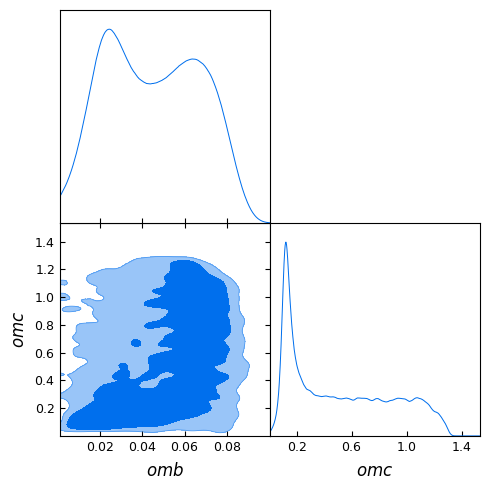

In [20]:
%matplotlib inline
import getdist.plots as gdplt

gdsamples = sampler.products(to_getdist=True)["sample"]
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["omb","omc"], filled=True)
print(np.shape(gdsamples[2]))

In [21]:
p = ["omb","omc","h","tau","ns","AS"]
s = gdsamples.samples[np.argmin(gdsamples.loglikes)]
for i in range(2):
    print("For the parameter ",p[i]," The acquired value is",s[i])

For the parameter  omb  The acquired value is 0.021594603468892904
For the parameter  omc  The acquired value is 0.11260409621708312


[cosmo1] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: h:68, ns:0.964
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {cosmo1: 148.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-06-11 20:14:52 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 5.037415 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


D:\Python\project_cosmology\cospo\lib\site-packages\cobaya\collection.py:651: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  self._data = pd.concat([


[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 10.856298 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 12.016155 after 192 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 320 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 2.134663 after 256 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 400 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 5.100435 after 320 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 480 samples accepted.
[mcmc]  - Acceptance rate: 0.997
[mcmc]  - Convergence of means: R-1 = 5.479212 after 

IndexError: index 4 is out of bounds for axis 0 with size 4

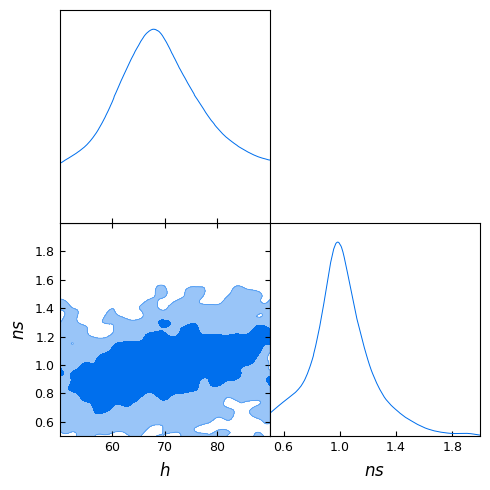

In [22]:
def cobaya_com2(h,ns):
    return (10 - np.log(Cosmo_Power(0.0224,0.12,h,0.0546,ns,2.0196)))

# below is parameters for 6 parameter cosmopower
info = {"likelihood": {"cosmo1": cobaya_com2}}
info["params"] = {
   "h": {"prior": {"min": 50, "max": 90}, "ref": 68, "proposal": 0.0001},
    "ns": {"prior": {"min": 0.5, "max": 2}, "ref": 0.964, "proposal": 0.000001}
}
info["sampler"] = {"mcmc": {"Rminus1_stop": 0.001, "max_tries": 1000}}
updated_info, sampler = run(info)

%matplotlib inline
import getdist.plots as gdplt

gdsamples = sampler.products(to_getdist=True)["sample"]
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["h","ns"], filled=True)
print(np.shape(gdsamples[2]))

p = ["omb","omc","h","tau","ns","AS"]
s = gdsamples.samples[np.argmin(gdsamples.loglikes)]

print("For the parameter ",p[2]," The acquired value is",s[2])
print("For the parameter ",p[4]," The acquired value is",s[4])

In [23]:
p = ["omb","omc","h","tau","ns","AS"]
s = gdsamples.samples[np.argmin(gdsamples.loglikes)]
for i in range(2):
    print("For the parameter ",p[i]," The acquired value is",s[i])

For the parameter  omb  The acquired value is 67.68379329355292
For the parameter  omc  The acquired value is 1.007801525538068
